In [1]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


## Testing Variational AutoEncoder using a manufactured dataset as input.

In [2]:
import sys
import imageio
import matplotlib.pyplot as plt

import h5py
import numpy as np
import os

# In order to execute this script, it is necessary to
# set the environment variable engine as "pytorch" before initializing
# simulai
os.environ['engine'] = 'pytorch'

# All the SimulAI imports 
from simulai.normalization import StandardNormalization
from simulai.metrics import L2Norm
from simulai.special import (Scattering, time_function, bidimensional_map_nonlin_1,
                            bidimensional_map_nonlin_2, bidimensional_map_nonlin_3)

from simulai.optimization import Optimizer
from simulai.file import SPFile

### Normalization.

In [3]:
def norm(data:np.ndarray=None, min_value:np.ndarray=None, max_value:np.ndarray=None) -> np.ndarray:

    return (data - min_value[None, :, None, None])/(max_value[None, :, None, None] - min_value[None, :, None, None])

### Generating manufactured datasets.

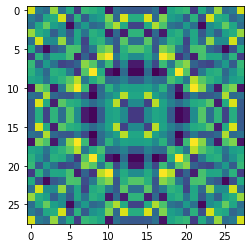

In [4]:
# Generating manufactured data 

# The dataset 'data' is two-dimensional in space and has the shape (n_timesteps, n_x, n_y, n_variables)
N_x = 28
N_y = 28
N_t = 2_000

x = np.linspace(0, 1, N_x)
y = np.linspace(0, 1, N_y)
t = np.linspace(0, 100, N_t)

T, X, Y = np.meshgrid(t, x, y, indexing="ij")

save_path = '.'
train = True

generator = Scattering(root=time_function, scatter_op=bidimensional_map_nonlin_3)
data = generator.exec(data=T, scatter_data=(X, Y, 0.5, 0.5))
data = data.reshape(data.shape + (1,))
data = data.transpose(0, 3, 1, 2)
# Plotting the last snapshot
plt.imshow(data[-1, 0, ...])
plt.show()

### Defining datasets sizes.

In [5]:
n_samples = data.shape[0]
train_size = int(0.6*n_samples)
dev_size = int(0.2*n_samples)
test_size = int(0.2*n_samples)

### Global parameters.

In [6]:
lr = 1e-3
train_fraction = 0.9
n_samples_train = int(train_fraction*n_samples)
n_epochs = 10_000 #100_000
sample_rate = 1
batch_size = 1_00

### Subdividing datasets.

In [7]:
data_train_ = data[:n_samples_train]
data_test_ = data[n_samples_train:]

min_value = data_train_.min((0,2,3))
max_value = data_train_.max((0,2,3))

data_train = norm(data=data_train_, min_value=min_value, max_value=max_value)
data_test = norm(data=data_test_, min_value=min_value, max_value=max_value)

n_inputs = 3
n_outputs = 3

### Model template.

In [8]:
def model():

    from simulai.regression import ConvolutionalNetwork, SLFNN
    from simulai.models import AutoencoderVariational

    n_inputs = 1
    n_outputs = 1
    transpose = False
    activation = 'relu'

    ### Layers Configurations ####
    ### BEGIN
    encoder_layers = [

        {'in_channels': n_inputs, 'out_channels': 16, 'kernel_size': 3, 'stride': 1, 'padding': 1,
         'after_conv': {'type': 'maxpool2d', 'kernel_size': 2, 'stride': 2}},

        {'in_channels': 16, 'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1,
         'after_conv': {'type': 'maxpool2d', 'kernel_size': 2, 'stride': 2}}
    ]

    bottleneck_encoder_layers = {
        'input_size': 1568,
        'output_size': 20,
        'activation': 'identity',
        'name': 'bottleneck_encoder'
    }

    bottleneck_decoder_layers = {
        'input_size': 20,
        'output_size': 1568,
        'activation': 'identity',
        'name': 'bottleneck_decoder'
    }


    decoder_layers = [

        {'in_channels': 32, 'out_channels': 16, 'kernel_size': 3, 'stride': 1, 'padding': 1,
         'before_conv': {'type': 'upsample', 'scale_factor': 2, 'mode': 'bicubic'}},

        {'in_channels': 16, 'out_channels': n_outputs, 'kernel_size': 3, 'stride': 1, 'padding': 1,
         'before_conv': {'type': 'upsample', 'scale_factor': 2, 'mode': 'bicubic'}}

    ]

    ### END
    ### Layers Configurations ####
    # Instantiating network
    encoder = ConvolutionalNetwork(layers=encoder_layers, activations=activation, case='2d', name="encoder")
    bottleneck_encoder = SLFNN(**bottleneck_encoder_layers)
    bottleneck_decoder = SLFNN(**bottleneck_decoder_layers)
    decoder = ConvolutionalNetwork(layers=decoder_layers, activations=activation, case='2d',
                                   transpose=transpose, name="decoder")

    autoencoder = AutoencoderVariational(encoder=encoder, bottleneck_encoder=bottleneck_encoder,
                                         bottleneck_decoder=bottleneck_decoder, decoder=decoder,
                                         encoder_activation=activation, devices='gpu')

    return autoencoder

### Instantiating model and executing training.

In [9]:
autoencoder = model()

autoencoder.summary(input_shape=list(data_train.shape))

optimizer_config = {'lr': lr,  'n_samples': n_samples_train}
weights = [1]

params = {'lambda_1': 0., 'lambda_2': 0., 'use_mean': False, 'relative': True}

optimizer = Optimizer('adam', params=optimizer_config, lr_decay_scheduler_params={'name': 'ExponentialLR',
                                                                                          'gamma': 0.9,
                                                                                          'decay_frequency': 10_000})

optimizer.fit(op=autoencoder, input_data=data_train, target_data=data_train,
              n_epochs=n_epochs, loss="vaermse", params=params, batch_size=batch_size, device='gpu')

saver = SPFile(compact=False)
saver.write(save_dir=save_path, name=f'autoencoder_rb_variational', model=autoencoder, template=model, device='cpu')

OrderedDict([ ( 'Identity_0',
                { 'Input shape': [None, 1, 28, 28],
                  'Output shape': [None, 1, 28, 28]}),
              ( 'Conv2d_0',
                { 'Input shape': [None, 1, 28, 28],
                  'Output shape': [None, 16, 28, 28]}),
              ('Activation_0', ReLU()),
              ( 'MaxPool2d_0',
                { 'Input shape': [None, 16, 28, 28],
                  'Output shape': [None, 16, 14, 14]}),
              ( 'Identity_1',
                { 'Input shape': [None, 16, 14, 14],
                  'Output shape': [None, 16, 14, 14]}),
              ( 'Conv2d_1',
                { 'Input shape': [None, 16, 14, 14],
                  'Output shape': [None, 32, 14, 14]}),
              ('Activation_1', Identity()),
              ( 'MaxPool2d_1',
                { 'Input shape': [None, 32, 14, 14],
                  'Output shape': [None, 32, 7, 7]})])
Summary of the network properties:
Linear operations layers:

[Linear(in_features=1568, 

### Reloading model from disk and executing predictions.

In [10]:
saver = SPFile(compact=False)
autoencoder_reload = saver.read(model_path=os.path.join(save_path, f"autoencoder_rb_variational"))
autoencoder_reload.summary(input_shape=list(data_train.shape))

approximated_data = autoencoder_reload.eval(input_data=data_test[:])

l2_norm = L2Norm()

error = 100*l2_norm(data=approximated_data, reference_data=data_test[::], relative_norm=True)

print(f"Projection error: {error} %")

import torch

batches = np.array_split(np.arange(data.shape[0]), int(data.shape[0]/1_000))

latent_series = list()
for i, batch in enumerate(batches):

    print(f"Projecting batch {i}.")
    latent_series.append(autoencoder_reload.project(input_data=torch.from_numpy(data[batch].astype('float32'))).detach().numpy())

latent_series = np.vstack(latent_series)

OrderedDict([ ( 'Identity_0',
                { 'Input shape': [None, 1, 28, 28],
                  'Output shape': [None, 1, 28, 28]}),
              ( 'Conv2d_0',
                { 'Input shape': [None, 1, 28, 28],
                  'Output shape': [None, 16, 28, 28]}),
              ('Activation_0', ReLU()),
              ( 'MaxPool2d_0',
                { 'Input shape': [None, 16, 28, 28],
                  'Output shape': [None, 16, 14, 14]}),
              ( 'Identity_1',
                { 'Input shape': [None, 16, 14, 14],
                  'Output shape': [None, 16, 14, 14]}),
              ( 'Conv2d_1',
                { 'Input shape': [None, 16, 14, 14],
                  'Output shape': [None, 32, 14, 14]}),
              ('Activation_1', Identity()),
              ( 'MaxPool2d_1',
                { 'Input shape': [None, 32, 14, 14],
                  'Output shape': [None, 32, 7, 7]})])
Summary of the network properties:
Linear operations layers:

[Linear(in_features=1568, 

### Observing the latent dynamics

Text(0, 0.5, 'Series 20')

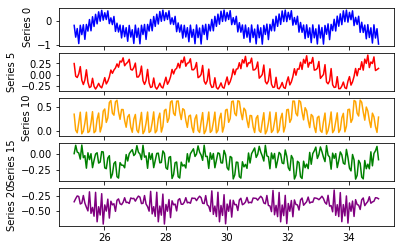

In [17]:
interval = [500, 700]
fig, axs = plt.subplots(5, 1, sharex='col')
t_ = t[slice(*interval)]

axs[0].plot(t_, latent_series[slice(*interval), 0], color='blue')
axs[0].set_ylabel(r"Series 0")

axs[1].plot(t_, latent_series[slice(*interval), 5], color='red')
axs[1].set_ylabel("Series 5")

axs[2].plot(t_, latent_series[slice(*interval),10], color='orange')
axs[2].set_ylabel("Series 10")

axs[3].plot(t_, latent_series[slice(*interval),15], color='green')
axs[3].set_ylabel("Series 15")

axs[4].plot(t_, latent_series[slice(*interval),-1], color='purple')
axs[4].set_ylabel("Series 20")

### Comparing reconstruction and ground truth.

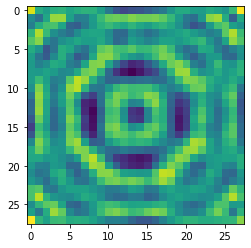

In [12]:
plt.close()
plt.imshow(approximated_data[-1, 0, ...])
plt.show()

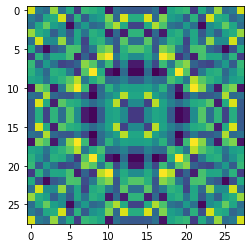

In [13]:
plt.imshow(data_test[-1, 0, ...])
plt.show()

In [14]:
optimizer.loss_states

{'loss': array([0.97300446, 0.9262808 , 0.86647087, ..., 0.08184685, 0.0834108 ,
        0.08341156]),
 'kl_loss': array([0.01713962, 0.02194542, 0.02449647, ..., 0.00159131, 0.00157843,
        0.00156855])}

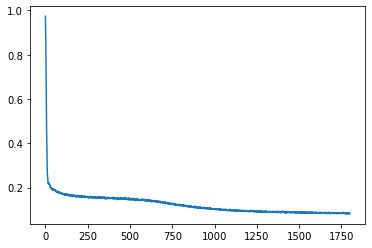

In [15]:
plt.plot(optimizer.loss_states['loss'])

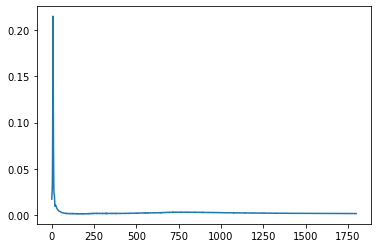

In [16]:
plt.plot(optimizer.loss_states['kl_loss'])